In [8]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import datetime

from models import DeepNetwork, DeepEnsemble
from utils import evaluate_sharpe, get_crossval_dataloaders, unload_data
from train import training, validate, train_ensembles, run_all_subsets

print(torch.cuda.is_available())

True


In [23]:
data_path = "./deep_learning/datasets/CharAll_na_rm_huge_train_variableall4_sentiment_full_new.npz"
split_lists = np.load('./deep_learning/sampling_folds/random_sampling_folds.npy', allow_pickle = True)
dataset = np.load(data_path)
data = dataset['data']

In [2]:
subset2col = {
	'flow+fund_mom+sentiment': list(range(56, 60))+[47],
	'fund_ex_mom_flow': [59]+ [x for x in range(46, 58) if x not in (list(range(54, 58))+[47])],
	'stock': range(46),
	'fund': range(46, 59),
	'fund+sentiment': range(46, 60),
	'stock+fund': range(59),
	'F_r12_2+sentiment': [58, 59],
	'stock+sentiment': [59]+list(range(0, 46)),
	'stock+fund+sentiment': range(60),
	'F_r12_2+flow+sentiment': [47, 58, 59]
}

In [4]:
config = {
	'data_path': "./deep_learning/datasets/CharAll_na_rm_huge_train_variableall4_sentiment_full_new.npz",
	'split_lists_path': './deep_learning/sampling_folds/random_sampling_folds.npy',
	'subset': 'fund+sentiment',
	'num_layers': 1,
	'hidden_dim': [2**6],
	'dropout': 0.,
	'learning_rate': 0.001,
	'epochs': 512,
	'weighted_loss': False,
	'reg_l1': 0.0,
	'reg_l2': 0.001,
	'batch_size': 300000,
	'criteria': 'Factor_sharpe',
	'ensemble_members': 8,
	'random_seed': 15,
	'device': 'cuda' if torch.cuda.is_available() else 'cpu',
	'num_workers': 4
}

config['split_lists'] = np.load(config['split_lists_path'], allow_pickle = True)
config['input_dim'] = len(subset2col[config['subset']])

In [59]:
model = DeepNetwork(config).to(device=config['device'])
print(model)

Deep_Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=14, out_features=64, bias=True)
  )
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
)


In [41]:
crossval_loaders, masks = get_crossval_dataloaders(config['data_path'], config['split_lists'], 'fund+sentiment', batch_size=config['batch_size'])

for i in range(len(crossval_loaders)):
	print('Cross-validation fold {}'.format(i+1))
	for j in crossval_loaders[i]['datasets']:
		print(len(j))
	print('')

Cross-validation fold 1
208161
68181
130816

Cross-validation fold 2
198258
68181
140719

Cross-validation fold 3
208191
63344
135623



In [42]:
fold = 0
train, val, test = crossval_loaders[fold]['datasets']
train_loader, val_loader, test_loader = crossval_loaders[fold]['dataloaders']
train_mask, val_mask, test_mask = masks[fold]

In [43]:
optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['reg_l2'])
criterion = torch.nn.MSELoss()

best_model_state = model.state_dict()
best_val_loss = torch.tensor(float('inf'))
best_val_sharpe = torch.tensor(-float('inf'))
sharpe_train = []
sharpe_val = []
loss_train = []
loss_val = []

run = 0
time_start = time.time()
for epoch in range(config['epochs']):
	epoch_loss = torch.tensor(0.0)
	y_train = []
	y_pred_train = []
	for i, (X, y) in enumerate(train_loader):
		X, y = X.float().to(config['device']), y.float().to(config['device'])
		optimizer.zero_grad()
		y_pred = model(X)
		
		loss = criterion(y_pred, y)	
		loss.backward()
		optimizer.step()	
		epoch_loss += loss.detach().cpu().item()
		
		y_train.append(y.detach().cpu())
		y_pred_train.append(y_pred.detach().cpu())
		
	epoch_loss /= i + 1
	y_train = torch.cat(y_train, dim=0)
	y_pred_train = torch.cat(y_pred_train, dim=0)
	
	sharpe_train_value = evaluate_sharpe(y_pred_train, y_train, train_mask)
	epoch_sharpe = sharpe_train_value
	sharpe_train.append(epoch_sharpe)
	loss_train.append(epoch_loss)
	
	# Validation
	with torch.no_grad():
		epoch_val_loss = torch.tensor(0.0)
		y_val = []
		y_pred_val = []
		for i, (X, y) in enumerate(val_loader):
			X, y = X.float().to(config['device']), y.float().to(config['device'])
			y_pred = model(X)
			loss = criterion(y_pred, y)
			epoch_val_loss += loss.detach().cpu().item()
			
			y_val.append(y.detach().cpu())
			y_pred_val.append(y_pred.detach().cpu())
			
	epoch_val_loss /= i + 1
	y_val = torch.cat(y_val, dim=0)
	y_pred_val = torch.cat(y_pred_val, dim=0)
	
	sharpe_val_value = evaluate_sharpe(y_pred_val, y_val, val_mask)
	epoch_val_sharpe = sharpe_val_value
	sharpe_val.append(epoch_val_sharpe)
	loss_val.append(epoch_val_loss)
	
	if epoch <= 50 or epoch % 10 == 0:
		print('Epoch {} - Training Loss: {:.8f}, Val Loss: {:.8f}, Train Sharpe: {:.8f}, Validation Sharpe: {:.8f}'.format(epoch+1, epoch_loss, epoch_val_loss, epoch_sharpe, epoch_val_sharpe))
	
	if config['criteria'] == 'Factor_sharpe':
		if epoch_val_sharpe > best_val_sharpe:
			best_val_sharpe = epoch_val_sharpe
			best_model_state = model.state_dict()
			print("Best model updated at epoch {}".format(epoch+1))
			if epoch > 50 and epoch % 10 != 0:
				print('Epoch {} - Training Loss: {:.8f}, Val Loss: {:.8f}, Train Sharpe: {:.8f}, Validation Sharpe: {:.8f}'.format(epoch+1, epoch_loss, epoch_val_loss, epoch_sharpe, epoch_val_sharpe))
	
	elif epoch_val_loss < best_val_loss:
		best_val_loss = epoch_val_loss
		best_model_state = model.state_dict()
		print("Best model updated at epoch {}".format(epoch+1))
		if epoch > 50 and epoch % 10 != 0:
			print('Epoch {} - Training Loss: {:.8f}, Val Loss: {:.8f}, Train Sharpe: {:.8f}, Validation Sharpe: {:.8f}'.format(epoch+1, epoch_loss, epoch_val_loss, epoch_sharpe, epoch_val_sharpe))

exp_path = './Experiments/'
exp_subset_path = os.path.join(exp_path, config['subset'])
if not os.path.exists(exp_subset_path):
	os.makedirs(exp_subset_path)

model.load_state_dict(best_model_state)
time_stamp = datetime.datetime.today().strftime('%Y%m%d_%H%M')
model_save_path = os.path.join(exp_subset_path, 'fold' + str(fold+1) + '_' + 'model' + str(run) + '_' + config['subset'] + '_' + time_stamp + '.pth')
torch.save(model, model_save_path)

duration = time.time() - time_start
print('Training completed in {:.0f}m {:.0f}s'.format(duration // 60, duration % 60))

Epoch 1 - Training Loss: 0.02872809, Val Loss: 0.02857450, Train Sharpe: 0.18978538, Validation Sharpe: -0.00351208
Best model updated at epoch 1
Epoch 2 - Training Loss: 0.02539634, Val Loss: 0.02517699, Train Sharpe: 0.18991265, Validation Sharpe: 0.00241252
Best model updated at epoch 2
Epoch 3 - Training Loss: 0.02231650, Val Loss: 0.02205317, Train Sharpe: 0.17910929, Validation Sharpe: -0.02640941
Epoch 4 - Training Loss: 0.01948923, Val Loss: 0.01920264, Train Sharpe: 0.16443709, Validation Sharpe: 0.01476136
Best model updated at epoch 4
Epoch 5 - Training Loss: 0.01691399, Val Loss: 0.01662318, Train Sharpe: 0.15174508, Validation Sharpe: 0.02448581
Best model updated at epoch 5
Epoch 6 - Training Loss: 0.01458881, Val Loss: 0.01431057, Train Sharpe: 0.14126463, Validation Sharpe: 0.03273516
Best model updated at epoch 6
Epoch 7 - Training Loss: 0.01250974, Val Loss: 0.01225867, Train Sharpe: 0.12613229, Validation Sharpe: 0.01536841
Epoch 8 - Training Loss: 0.01067082, Val Lo

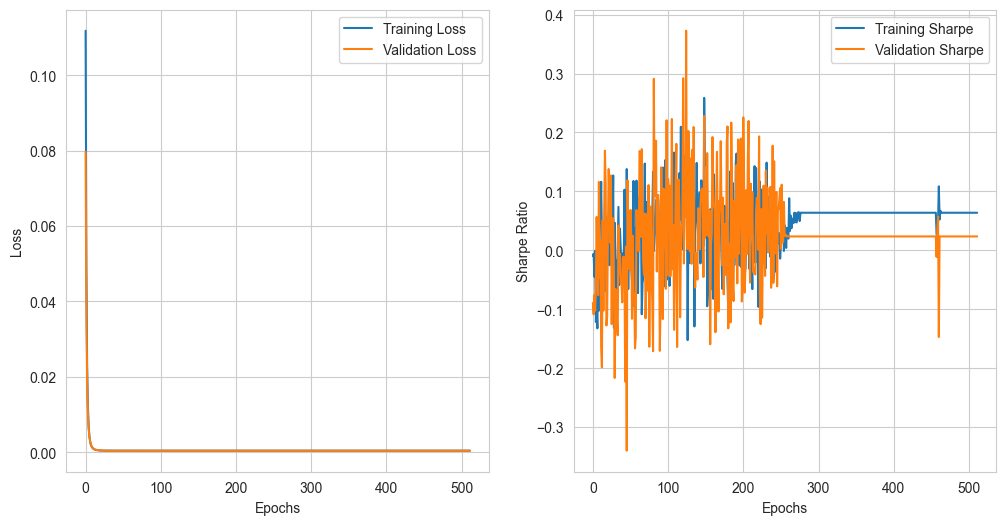

In [31]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(loss_train, label='Training Loss')
plt.plot(loss_val, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(sharpe_train, label='Training Sharpe')
plt.plot(sharpe_val, label='Validation Sharpe')
plt.xlabel('Epochs')
plt.ylabel('Sharpe Ratio')
plt.legend()
plt.show()

In [ ]:
ensemble_members = 8
fold = 0

crossval_loaders, masks = get_crossval_dataloaders(config['data_path'], config['split_lists'], config['subset'], batch_size=config['batch_size'])
train, val, test = crossval_loaders[fold]['datasets']
train_loader, val_loader, test_loader = crossval_loaders[fold]['dataloaders']
train_mask, val_mask, test_mask = masks[fold]

avg_loss = {'train': 0.0, 'val': 0.0, 'test': 0.0}
avg_sharpe = {'train': 0.0, 'val': 0.0, 'test': 0.0}

for run in range(ensemble_members):
	print('Running ensemble member no. {}'.format(run+1))
	model = DeepNetwork(config).to(device=config['device'])
	model, loss_train, loss_val, sharpe_train, sharpe_val, best_epoch = training(model, train_loader, val_loader, train_mask, val_mask, config, fold, run)
	test_loss, test_sharpe = validate(model, test_loader, test_mask, torch.nn.MSELoss(), config)
	
	avg_loss['train'] += loss_train[best_epoch]
	avg_loss['val'] += loss_val[best_epoch]
	avg_loss['test'] += test_loss
	
	avg_sharpe['train'] += sharpe_train[best_epoch]
	avg_sharpe['val'] += sharpe_val[best_epoch]
	avg_sharpe['test'] += test_sharpe

avg_loss = {key: value / (run+1) for key, value in avg_loss.items()}
avg_sharpe = {key: value / (run+1) for key, value in avg_sharpe.items()}

In [7]:
crossval_loaders, masks = get_crossval_dataloaders(config['data_path'], config['split_lists'], config['subset'], batch_size=config['batch_size'])

avg_loss_fold = {'train': 0.0, 'val': 0.0, 'test': 0.0}
avg_sharpe_fold = {'train': 0.0, 'val': 0.0, 'test': 0.0}

for fold in range(len(crossval_loaders)):
	print('\nRUNNING FOLD NO. {}'.format(fold+1))
	avg_loss_ens, avg_sharpe_ens = train_ensembles(config, crossval_loaders, masks, fold, config['ensemble_members'])
	
	avg_loss_fold['train'] += avg_loss_ens['train']
	avg_loss_fold['val'] += avg_loss_ens['val']
	avg_loss_fold['test'] += avg_loss_ens['test']
	
	avg_sharpe_fold['train'] += avg_sharpe_ens['train']
	avg_sharpe_fold['val'] += avg_sharpe_ens['val']
	avg_sharpe_fold['test'] += avg_sharpe_ens['test']

avg_loss_fold = {key: value / (len(crossval_loaders)) for key, value in avg_loss_fold.items()}
avg_sharpe_fold = {key: value / (len(crossval_loaders)) for key, value in avg_sharpe_fold.items()}

print(avg_loss_fold)
print(avg_sharpe_fold)


RUNNING FOLD NO. 1

TRAINING ENSEMBLE MEMBER 1
Epoch 1 - Training Loss: 0.00719792, Val Loss: 0.00672514, Train Sharpe: -0.17059104, Validation Sharpe: -0.16196084
Best model updated at epoch 1
Epoch 2 - Training Loss: 0.00589450, Val Loss: 0.00551381, Train Sharpe: -0.16686632, Validation Sharpe: -0.20798695
Epoch 3 - Training Loss: 0.00486706, Val Loss: 0.00459242, Train Sharpe: -0.16529635, Validation Sharpe: -0.20762973
Epoch 4 - Training Loss: 0.00410437, Val Loss: 0.00393244, Train Sharpe: -0.17694706, Validation Sharpe: -0.20383722
Epoch 5 - Training Loss: 0.00357805, Val Loss: 0.00348807, Train Sharpe: -0.17902026, Validation Sharpe: -0.17700179
Epoch 6 - Training Loss: 0.00324291, Val Loss: 0.00319936, Train Sharpe: -0.17015506, Validation Sharpe: -0.17527135
Epoch 7 - Training Loss: 0.00304036, Val Loss: 0.00300372, Train Sharpe: -0.17288339, Validation Sharpe: -0.09014613
Best model updated at epoch 7
Epoch 8 - Training Loss: 0.00291008, Val Loss: 0.00284890, Train Sharpe: 

In [9]:
avg_sharpe_fold_ens = 0.
for fold in range(len(crossval_loaders)):
	model_dirs = os.path.join('./Experiments/', config['subset'], 'fold' + str(fold+1))
	ensemble = DeepEnsemble(config, model_dirs)
	
	crossval_loaders, masks = get_crossval_dataloaders(config['data_path'], config['split_lists'], config['subset'], batch_size=config['batch_size'])
	_, _, test_loader = crossval_loaders[fold]['dataloaders']
	X_test, y_test = unload_data(test_loader)
	_, _, test_mask = masks[fold]
	
	ens_pred_test = ensemble.predict(X_test.float().to(config['device']))
	sharpe_test = evaluate_sharpe(ens_pred_test, y_test, test_mask)
	print(sharpe_test)
	avg_sharpe_fold_ens += sharpe_test

avg_sharpe_fold_ens /= len(crossval_loaders)
print(avg_sharpe_fold_ens)

0.2791329795217465
0.2696935834940383
0.35179379455751314
0.300206785857766


In [10]:
config['subset'] = 'fund_ex_mom_flow'
config['input_dim'] = len(subset2col[config['subset']])

In [11]:
crossval_loaders, masks = get_crossval_dataloaders(config['data_path'], config['split_lists'], config['subset'], batch_size=config['batch_size'])

avg_loss_fold = {'train': 0.0, 'val': 0.0, 'test': 0.0}
avg_sharpe_fold = {'train': 0.0, 'val': 0.0, 'test': 0.0}

for fold in range(len(crossval_loaders)):
	print('\nRUNNING FOLD NO. {}'.format(fold+1))
	avg_loss_ens, avg_sharpe_ens = train_ensembles(config, crossval_loaders, masks, fold, config['ensemble_members'])
	
	avg_loss_fold['train'] += avg_loss_ens['train']
	avg_loss_fold['val'] += avg_loss_ens['val']
	avg_loss_fold['test'] += avg_loss_ens['test']
	
	avg_sharpe_fold['train'] += avg_sharpe_ens['train']
	avg_sharpe_fold['val'] += avg_sharpe_ens['val']
	avg_sharpe_fold['test'] += avg_sharpe_ens['test']

avg_loss_fold = {key: value / (len(crossval_loaders)) for key, value in avg_loss_fold.items()}
avg_sharpe_fold = {key: value / (len(crossval_loaders)) for key, value in avg_sharpe_fold.items()}

print(avg_loss_fold)
print(avg_sharpe_fold)


RUNNING FOLD NO. 1

TRAINING ENSEMBLE MEMBER 1
Epoch 1 - Training Loss: 0.00795087, Val Loss: 0.00588146, Train Sharpe: 0.07041503, Validation Sharpe: 0.07446039
Best model updated at epoch 1
Epoch 2 - Training Loss: 0.00644604, Val Loss: 0.00485150, Train Sharpe: 0.07293721, Validation Sharpe: 0.06424677
Epoch 3 - Training Loss: 0.00521732, Val Loss: 0.00407528, Train Sharpe: 0.10367793, Validation Sharpe: 0.06405571
Epoch 4 - Training Loss: 0.00425362, Val Loss: 0.00353431, Train Sharpe: 0.11754669, Validation Sharpe: 0.06548375
Epoch 5 - Training Loss: 0.00353999, Val Loss: 0.00320025, Train Sharpe: 0.11164783, Validation Sharpe: 0.06147337
Epoch 6 - Training Loss: 0.00305281, Val Loss: 0.00303390, Train Sharpe: 0.11479280, Validation Sharpe: 0.07213026
Epoch 7 - Training Loss: 0.00275757, Val Loss: 0.00298697, Train Sharpe: 0.11601207, Validation Sharpe: 0.07194222
Epoch 8 - Training Loss: 0.00260956, Val Loss: 0.00300731, Train Sharpe: 0.12464966, Validation Sharpe: 0.10155867
Be

In [12]:
avg_sharpe_fold_ens = 0.
for fold in range(len(crossval_loaders)):
	model_dirs = os.path.join('./Experiments/', config['subset'], 'fold' + str(fold+1))
	ensemble = DeepEnsemble(config, model_dirs)
	
	crossval_loaders, masks = get_crossval_dataloaders(config['data_path'], config['split_lists'], config['subset'], batch_size=config['batch_size'])
	_, _, test_loader = crossval_loaders[fold]['dataloaders']
	X_test, y_test = unload_data(test_loader)
	_, _, test_mask = masks[fold]
	
	ens_pred_test = ensemble.predict(X_test.float().to(config['device']))
	sharpe_test = evaluate_sharpe(ens_pred_test, y_test, test_mask)
	print(sharpe_test)
	avg_sharpe_fold_ens += sharpe_test

avg_sharpe_fold_ens /= len(crossval_loaders)
print(avg_sharpe_fold_ens)

0.00015002249363720127
0.10384931098224807
0.06541024123059637
0.056469858235493886


In [13]:
config['subset'] = 'stock+fund'
config['input_dim'] = len(subset2col[config['subset']])

In [14]:
crossval_loaders, masks = get_crossval_dataloaders(config['data_path'], config['split_lists'], config['subset'], batch_size=config['batch_size'])

avg_loss_fold = {'train': 0.0, 'val': 0.0, 'test': 0.0}
avg_sharpe_fold = {'train': 0.0, 'val': 0.0, 'test': 0.0}

for fold in range(len(crossval_loaders)):
	print('\nRUNNING FOLD NO. {}'.format(fold+1))
	avg_loss_ens, avg_sharpe_ens = train_ensembles(config, crossval_loaders, masks, fold, config['ensemble_members'])
	
	avg_loss_fold['train'] += avg_loss_ens['train']
	avg_loss_fold['val'] += avg_loss_ens['val']
	avg_loss_fold['test'] += avg_loss_ens['test']
	
	avg_sharpe_fold['train'] += avg_sharpe_ens['train']
	avg_sharpe_fold['val'] += avg_sharpe_ens['val']
	avg_sharpe_fold['test'] += avg_sharpe_ens['test']

avg_loss_fold = {key: value / (len(crossval_loaders)) for key, value in avg_loss_fold.items()}
avg_sharpe_fold = {key: value / (len(crossval_loaders)) for key, value in avg_sharpe_fold.items()}

print(avg_loss_fold)
print(avg_sharpe_fold)


RUNNING FOLD NO. 1

TRAINING ENSEMBLE MEMBER 1
Epoch 1 - Training Loss: 0.00603832, Val Loss: 0.00469461, Train Sharpe: 0.07882871, Validation Sharpe: -0.13806669
Best model updated at epoch 1
Epoch 2 - Training Loss: 0.00463891, Val Loss: 0.00369856, Train Sharpe: 0.05762687, Validation Sharpe: -0.11643752
Best model updated at epoch 2
Epoch 3 - Training Loss: 0.00361832, Val Loss: 0.00305708, Train Sharpe: 0.02286245, Validation Sharpe: -0.13043977
Epoch 4 - Training Loss: 0.00295213, Val Loss: 0.00271160, Train Sharpe: -0.00409822, Validation Sharpe: -0.12544817
Epoch 5 - Training Loss: 0.00258435, Val Loss: 0.00257027, Train Sharpe: -0.05456625, Validation Sharpe: -0.12238123
Epoch 6 - Training Loss: 0.00242597, Val Loss: 0.00252870, Train Sharpe: -0.06002017, Validation Sharpe: -0.10852081
Best model updated at epoch 6
Epoch 7 - Training Loss: 0.00237447, Val Loss: 0.00250065, Train Sharpe: -0.07544077, Validation Sharpe: -0.07410219
Best model updated at epoch 7
Epoch 8 - Traini

In [16]:
avg_sharpe_fold_ens = 0.
for fold in range(len(crossval_loaders)):
	model_dirs = os.path.join('./Experiments/', config['subset'], 'fold' + str(fold+1))
	ensemble = DeepEnsemble(config, model_dirs)
	
	crossval_loaders, masks = get_crossval_dataloaders(config['data_path'], config['split_lists'], config['subset'], batch_size=config['batch_size'])
	_, _, test_loader = crossval_loaders[fold]['dataloaders']
	X_test, y_test = unload_data(test_loader)
	_, _, test_mask = masks[fold]
	
	ens_pred_test = ensemble.predict(X_test.float().to(config['device']))
	sharpe_test = evaluate_sharpe(ens_pred_test, y_test, test_mask)
	print(sharpe_test)
	avg_sharpe_fold_ens += sharpe_test

avg_sharpe_fold_ens /= len(crossval_loaders)
print(avg_sharpe_fold_ens)

0.09801895666399872
0.1920559573122067
0.14477015631698126
0.14494835676439558
